In [1]:
import numpy as np
import os
converters = {8: lambda x: x == '"True"'}
data_dir= 'http://cdn.gea.esac.esa.int/Gaia/gdr3/Astrophysical_parameters/total_galactic_extinction_map/'


map_fname = os.path.join(data_dir,'TotalGalacticExtinctionMap_001.csv.gz')
dtype = [('solution_id', 'i8'),('healpix_id', 'i8'),('healpix_level', 'i1'),('a0', 'f4'),('a0_uncertainty', 'f4'),('a0_min', 'f4'),('a0_max', 'f4'),('num_tracers_used', 'i4'),('optimum_hpx_flag', '?'),('status', 'i2')]
d = np.genfromtxt(map_fname, comments='#', delimiter=',',encoding='utf-8', converters=converters,dtype=dtype)

HPId
HPlevel
A0
e_A0
Ntracers


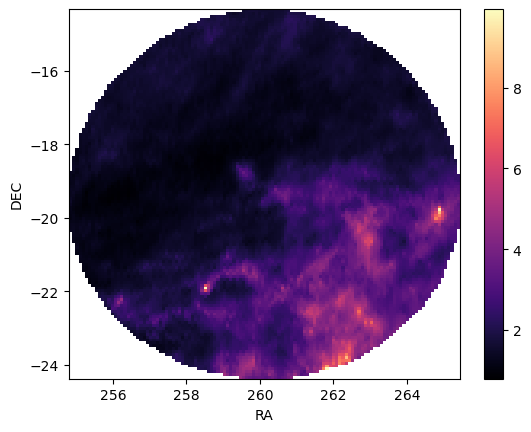

In [10]:
import os
import numpy as np
import healpy as hpp
from astropy.table import Table
import astropy.units as u
from astropy_healpix import HEALPix as hp
from astropy.coordinates import SkyCoord
from astropy.coordinates import Galactic
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
#cra=6+42/60+52.0/3600
#cdec=27+22/60+56/3600
level=9

ra = 260.10740722
dec = -19.3523078
hp = hp(nside=2**level, order='nested', frame='icrs')
coord = SkyCoord(ra*u.deg,dec*u.deg, frame='icrs')

ext_g=np.load('I_355_tgextmap.npz')
for k in ext_g.files:
    print(k)
h_id=ext_g['HPId']
a0=ext_g['A0']
numtr=ext_g['Ntracers']

search=hp.cone_search_skycoord(coord, radius=5 * u.deg)
common = h_id[np.isin(h_id,search)]
ext=a0[np.isin(h_id,search)]
tracers=numtr[np.isin(h_id,search)]

#nans=np.isnan(ext)
#ext=ext[~nans] 
#common=common[~nans]

cd=hp.healpix_to_skycoord(common)  
ra=np.unique(cd.ra.value)
dec=np.unique(cd.dec.value)
X,Y= np.meshgrid(ra,dec)

zi = griddata((cd.ra.value,cd.dec.value),np.array(ext) , (X, Y), method='linear')

plt.imshow(zi, cmap=plt.cm.magma, interpolation='none', extent=[X.min(), X.max(), Y.min(), Y.max()],origin='lower')
plt.colorbar()
plt.xlabel('RA')
plt.ylabel('DEC')
plt.show()
plt.close()


In [5]:
def nside_to_pixel_area(nside):
    """
    Find the area of HEALPix pixels given the pixel dimensions of one of
    the 12 'top-level' HEALPix tiles.
    """
    nside = np.asanyarray(nside, dtype=np.int64)
    npix = 12 * nside * nside
    pixel_area = 4 * np.pi / npix * u.sr
    return pixel_area

In [6]:
def nside_to_pixel_resolution(nside):
    """
    Find the resolution of HEALPix pixels given the pixel dimensions of one of
    the 12 'top-level' HEALPix tiles.
    """
    nside = np.asanyarray(nside, dtype=np.int64)
    return (nside_to_pixel_area(nside) ** 0.5).to(u.arcmin)

In [7]:
#calc resolution
f=nside_to_pixel_resolution(2**level)
print(f)

6.870972823634812 arcmin


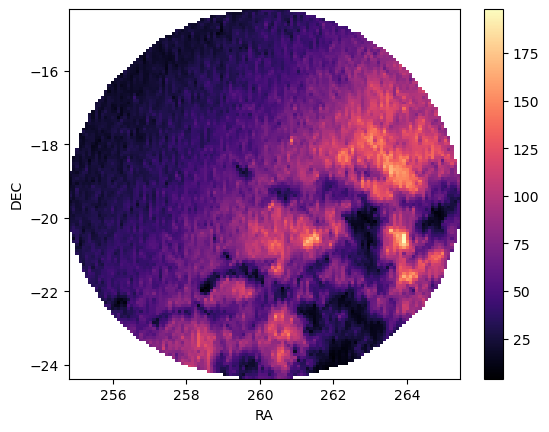

In [8]:
zi = griddata((cd.ra.value,cd.dec.value),np.array(tracers) , (X, Y), method='linear')

plt.imshow(zi, cmap=plt.cm.magma, interpolation='none', extent=[X.min(), X.max(), Y.min(), Y.max()],origin='lower')
plt.colorbar()
plt.xlabel('RA')
plt.ylabel('DEC')
plt.show()
plt.close()


HPId
HPlevel
A0
e_A0
Ntracers


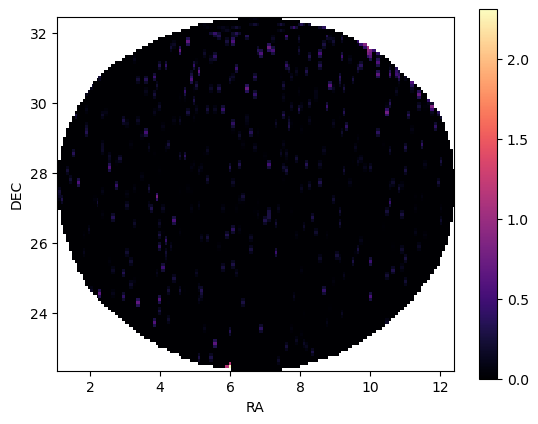

In [15]:
from astropy_healpix import HEALPix as hp
from astropy.coordinates import SkyCoord
from astropy.coordinates import Galactic
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
ra=6+42/60+52.0/3600
dec=27+22/60+56/3600
level=9
hp = hp(nside=2**level, order='nested', frame='icrs')
coord = SkyCoord(ra*u.deg,dec*u.deg, frame='icrs')

ext_g=np.load('I_355_tgextmap.npz')
for k in ext_g.files:
    print(k)
h_id=ext_g['HPId']
a0=ext_g['A0']
numtr=ext_g['Ntracers']

search=hp.cone_search_skycoord(coord, radius=5 * u.deg)
common = h_id[np.isin(h_id,search)]
ext=a0[np.isin(h_id,search)]
tracers=numtr[np.isin(h_id,search)]

#nans=np.isnan(ext)
#ext=ext[~nans] 
#common=common[~nans]

cd=hp.healpix_to_skycoord(common)  
ra=np.unique(cd.ra.value)
dec=np.unique(cd.dec.value)
X,Y= np.meshgrid(ra,dec)

zi = griddata((cd.ra.value,cd.dec.value),np.array(ext) , (X, Y), method='linear')

plt.imshow(zi, cmap=plt.cm.magma, interpolation='none', extent=[X.min(), X.max(), Y.min(), Y.max()],origin='lower')
plt.colorbar()
plt.xlabel('RA')
plt.ylabel('DEC')
plt.show()
plt.close()


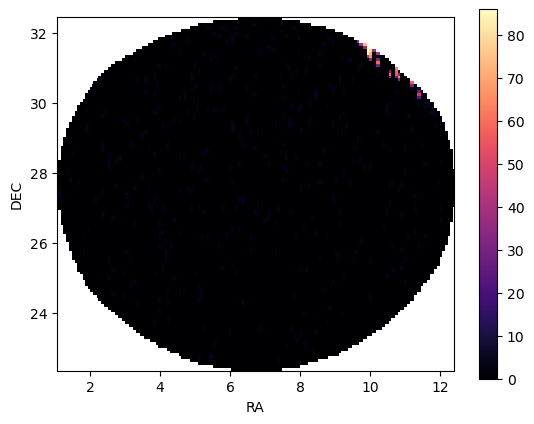

In [16]:
zi = griddata((cd.ra.value,cd.dec.value),np.array(tracers) , (X, Y), method='linear')

plt.imshow(zi, cmap=plt.cm.magma, interpolation='none', extent=[X.min(), X.max(), Y.min(), Y.max()],origin='lower')
plt.colorbar()
plt.xlabel('RA')
plt.ylabel('DEC')
plt.show()
plt.close()